In [30]:
from google.colab import drive
drive.mount('/gdrive')
root='/gdrive/MyDrive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn import metrics
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [32]:
df_org = pd.read_csv(root+"immo_data.csv", 
                  usecols=['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent']
                )

df = df_org.copy()



In [33]:
df.columns

Index(['serviceCharge', 'heatingType', 'telekomUploadSpeed', 'totalRent'], dtype='object')

In [34]:
df.head(2)

serviceCharge                     heatingType  telekomUploadSpeed  \
0          245.0                 central_heating                10.0   
1          134.0  self_contained_central_heating                10.0   

   totalRent  
0      840.0  
1        NaN

In [35]:
df.shape

(268850, 4)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   serviceCharge       261941 non-null  float64
 1   heatingType         223994 non-null  object 
 2   telekomUploadSpeed  235492 non-null  float64
 3   totalRent           228333 non-null  float64
dtypes: float64(3), object(1)
memory usage: 8.2+ MB


In [37]:
df.describe()

serviceCharge  telekomUploadSpeed     totalRent
count  261941.000000       235492.000000  2.283330e+05
mean      151.206113           28.804928  9.013315e+02
std       308.295790           16.337151  3.323833e+04
min         0.000000            1.000000  0.000000e+00
25%        95.000000           10.000000  4.698000e+02
50%       135.000000           40.000000  6.500000e+02
75%       190.000000           40.000000  9.850000e+02
max    146118.000000          100.000000  1.575154e+07

In [38]:
for col in df.columns:
    print(col," =>", df[col].isnull().sum()/len(df[col])*100)

serviceCharge  => 2.5698344801934163
heatingType  => 16.68439650362656
telekomUploadSpeed  => 12.407662265203644
totalRent  => 15.070485400781106


In [39]:
df.serviceCharge.fillna(df.serviceCharge.median(), inplace=True)
#df.heatingType.fillna(df.heatingType.mode()[0], inplace=True)
df.telekomUploadSpeed.fillna(df.telekomUploadSpeed.median(), inplace=True)
df.totalRent.fillna(df.totalRent.median(), inplace=True)

In [40]:
kurt = df.kurt(numeric_only=True)[:]
kurt
# Return unbiased kurtosis over requested axis using Fisher's definition of kurtosis (kurtosis of normal == 0.0).
# The result is normalized by N-1

serviceCharge         197151.674512
telekomUploadSpeed        -0.765917
totalRent             260044.391607
dtype: float64

In [41]:
outliers = ['serviceCharge', 'totalRent']

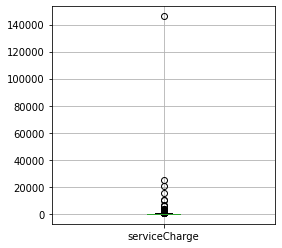

In [42]:
for col in outliers:
    plt.figure(figsize=(4, 4))
    df.boxplot(column=[col])

In [43]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [44]:
for col in outliers:
    print(f'{col}: {len(outliers_iqr(df[col])[0])}')

serviceCharge: 10271
totalRent: 20025


In [45]:
def outliers_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [46]:
for col in outliers:
    print(f'{col}: {len(outliers_z_score(df[col])[0])}')

serviceCharge: 98
totalRent: 6


In [47]:
for i in outliers:
    quartile_1, quartile_3 = np.percentile(df[i], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df = df[df[i]<upper_bound]
    df = df[df[i]>lower_bound]

In [48]:
df.heatingType.value_counts()

central_heating                   119085
district_heating                   22260
gas_heating                        18191
self_contained_central_heating     18058
floor_heating                      12100
oil_heating                         4642
heat_pump                           2175
combined_heat_and_power_plant       1519
night_storage_heater                1322
electric_heating                     871
wood_pellet_heating                  780
stove_heating                        335
solar_heating                        128
Name: heatingType, dtype: int64

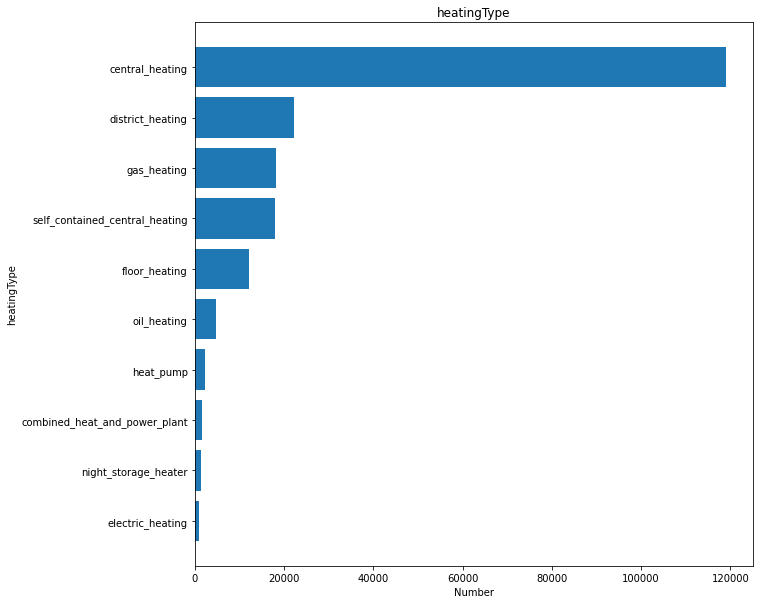

In [49]:
plt.figure(figsize=(10, 10))
data = df.heatingType.value_counts()[:10]
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("heatingType")
plt.ylabel("heatingType")
plt.xlabel("Number")

plt.barh(x, y)
plt.show()

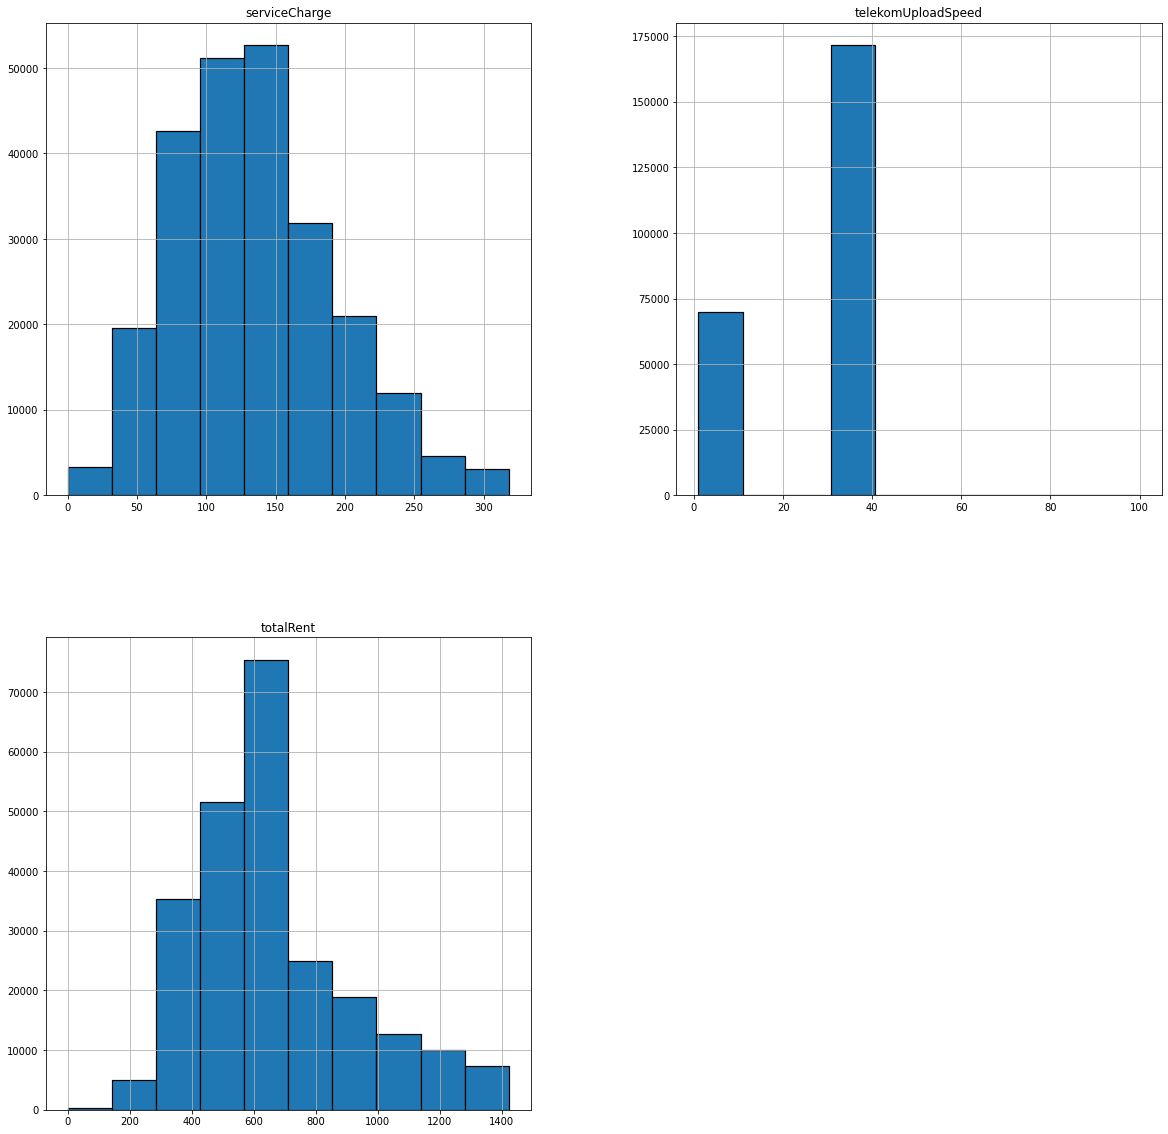

In [50]:
# Visualizing the distribution for every "feature"
df.hist(edgecolor="black", linewidth=1.2, figsize=(20, 20))
plt.show()

In [51]:
df.corr()

serviceCharge  telekomUploadSpeed  totalRent
serviceCharge            1.000000            0.026520   0.528393
telekomUploadSpeed       0.026520            1.000000   0.039919
totalRent                0.528393            0.039919   1.000000

In [53]:
df_copy = df.copy()
df_copy['serviceCharge-2'] = df.serviceCharge ** 2
df_copy['telekomUploadSpeed-2'] = df.telekomUploadSpeed ** 2
df_copy['serviceCharge-3'] = df.serviceCharge ** 3
df_copy['telekomUploadSpeed-3'] = df.telekomUploadSpeed ** 3

df_copy.corr()



serviceCharge  telekomUploadSpeed  totalRent  \
serviceCharge              1.000000            0.026520   0.528393   
telekomUploadSpeed         0.026520            1.000000   0.039919   
totalRent                  0.528393            0.039919   1.000000   
serviceCharge-2            0.967262            0.021641   0.536230   
telekomUploadSpeed-2       0.021715            0.979282   0.029014   
serviceCharge-3            0.902703            0.017287   0.506327   
telekomUploadSpeed-3       0.015366            0.843032   0.017061   

                      serviceCharge-2  telekomUploadSpeed-2  serviceCharge-3  \
serviceCharge                0.967262              0.021715         0.902703   
telekomUploadSpeed           0.021641              0.979282         0.017287   
totalRent                    0.536230              0.029014         0.506327   
serviceCharge-2              1.000000              0.016844         0.980522   
telekomUploadSpeed-2         0.016844              1.000000         0.012814   
serviceCharge-3              0.980522              0.012814         1.000000   
telekomUploadSpeed-3         0.011017              0.930318         0.007688   

                      telekomUploadSpeed-3  
serviceCharge                     0.015366  
telekomUploadSpeed                0.843032  
totalRent                         0.017061  
serviceCharge-2                   0.011017  
telekomUploadSpeed-2              0.930318  
serviceCharge-3                   0.007688  
telekomUploadSpeed-3              1.000000

In [54]:
df['serviceCharge'] = df.serviceCharge ** 2

In [55]:
y = df.pop('totalRent')
X = df

X.columns

Index(['serviceCharge', 'heatingType', 'telekomUploadSpeed'], dtype='object')

In [56]:


y = pd.DataFrame(data=y, columns=['totalRent'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

y_train.head(3)



totalRent
243734      650.0
225214      390.0
236989      650.0

In [57]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ss = StandardScaler()

preprocessor_x = ColumnTransformer(
    transformers=[
            ('serviceCharge', ss, ['serviceCharge']),
            ('telekomUploadSpeed', ss, ['telekomUploadSpeed']),
            ('heatingType', ohe, ['heatingType']),       
])
preprocessor_y = ColumnTransformer(
    transformers=[
            ('totalRent', ss, ['totalRent']),       
])

fitter_y = preprocessor_y.fit(y_train)
fitter_x = preprocessor_x.fit(X_train)

y_train = fitter_y.transform(y_train)
y_test = fitter_y.transform(y_test)
X_train = fitter_x.transform(X_train)
X_test = fitter_x.transform(X_test)

m, n = y_train.shape
x, z = y_test.shape
y_train = y_train.reshape(m, )
y_test = y_test.reshape(x, )

print(f'train x shape: {X_train.shape}')
print(f'train y shape: {y_train.shape}')
print(f'test x shape: {X_test.shape}')
print(f'test y shape: {y_test.shape}')

train x shape: (193416, 16)
train y shape: (193416,)
test x shape: (48354, 16)
test y shape: (48354,)



Scratch

In [58]:
# Linear reggression
class Net() :   
    def __init__( self, learning_rate=0.01 , iterations=1000 , method='mse') :
        self.learning_rate = learning_rate
        self.iterations = iterations 
        self.method = method

    
    # Function for model training        
    def fit( self, X, Y ) : 
        # no_of_training_examples, no_of_features
        self.m, self.n = X.shape 
        # weight initialization 
        self.W = np.random.normal(loc=0.0, scale=0.001, size=self.n)
        self.b = 0 
        self.X = X
        self.Y = Y 
        # gradient descent learning         
        for i in range( self.iterations ) :
            self.update_weights(X, Y)  
        return self
    
    
    # Helper function to update weights in gradient descent 
    def update_weights( self, X, Y ) :
        Y_pred = self.predict( X )
        # calculate gradients
        
        # Linear reggression with minimum square error
        if self.method == 'mse':
            error = (Y - Y_pred)
            dW = - ( 2 * ( X.T ).dot( error )  ) / self.m
            db = - 2 * np.sum( error ) / self.m
    
            
        # Linear reggression with minimum absolute error
        elif self.method == 'ae':
            error = abs(Y - Y_pred)
            error = np.where(error == 0, 0.01, error)
            dW = ( np.sum( X.T, axis=1)/ 4)
            print(dW.shape)
            db = np.sum( error ) / 4
        
        # Linear reggression with Epsilon Sensitive Error
        elif self.method == 'ese':
            threshold = 0.00001
            error = abs(Y - Y_pred)
            error = np.where(error < threshold, 0.01, error)
            dW = ( ( X.T ).dot( error )  )
            db = np.sum( error ) 
        
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db 
        return self
    
    # Hypothetical function  h( x )  
    def predict( self, X ) :
        return (X.dot( self.W ) + self.b)

Linear reggression with minimum square error

In [59]:
model_mse = Net(method='mse')

model_mse.fit(X_train, y_train)

In [60]:
print(model_mse.W)
print(model_mse.b)
y_pre_test_mse = model_mse.predict(X_test)
print('linear reggression from scrach (MSE) R^2: test', metrics.r2_score(y_test, y_pre_test_mse))

[ 0.52377244  0.02636068 -0.20870571  0.05902019 -0.15816368 -0.00242702
  0.3795323  -0.00342571  0.10372593 -0.02208626  0.00958297  0.02828245
  0.00621686 -0.00197877  0.02489584 -0.10322642]
0.11032643308510488
linear reggression from scrach (MSE) R^2: test 0.32048047638404453



# Sklearn pakage
LinearRegression

In [61]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)


y_pred_test = model_lr.predict(X_test)

model_lr.coef_



array([ 0.51223022,  0.0246136 , -0.32182774,  0.33174009, -0.32001211,
       -0.17133295,  0.45928791, -0.1385534 ,  0.47367246, -0.35380767,
       -0.11613356, -0.09918018,  0.44877745, -0.2405775 ,  0.28043269,
       -0.23248549])

In [62]:
print('linear reggression score train:', model_lr.score(X_train, y_train))
print('linear reggression R^2: test', metrics.r2_score(y_test, y_pred_test))

linear reggression score train: 0.32654198950167546
linear reggression R^2: test 0.327455473515763


 Ridge

In [63]:
model_ridge = Ridge(alpha=1)

model_ridge.fit(X_train, y_train)


y_pred_test_ridge = model_ridge.predict(X_test)

model_ridge.coef_



array([ 0.51223438,  0.02461421, -0.32156106,  0.331731  , -0.31973062,
       -0.17082566,  0.45950157, -0.13828095,  0.47366223, -0.35320816,
       -0.11584004, -0.09890831,  0.44484352, -0.23942491,  0.28025588,
       -0.23221448])

In [64]:
print('ridge reggression score train:', model_ridge.score(X_train, y_train))
print('ridge reggression R^2: test', metrics.r2_score(y_test, y_pred_test_ridge))

ridge reggression score train: 0.3265419759624949
ridge reggression R^2: test 0.3274539737367703


Lasso

In [65]:
model_lasso = Lasso(alpha=0.1)

model_lasso.fit(X_train, y_train)


y_pred_test_lasso = model_lasso.predict(X_test)

model_lasso.coef_



array([ 0.43647967,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ])

In [66]:
print('lasso reggression score train:', model_lasso.score(X_train, y_train))
print('lasso reggression R^2: test', metrics.r2_score(y_test, y_pred_test_lasso))

lasso reggression score train: 0.27781044133894617
lasso reggression R^2: test 0.27611655401942514
